In [1]:
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

In [2]:
driving_data_file_path = "../data-cleanup/merged-cleaned-csv/driving_data_merged_1_to_48.csv"
driving_data_original = pd.read_csv(driving_data_file_path)

In [3]:
driving_data_original.head()

,attempt,user_id,evis_id,timestamp,current_soc,energy_consumed,power_usage,range_estimate,speed,distance_traveled,throttle_position,break_position,wheel_rot,xPosition,road_elevation,zPosition,tripMeter,odoMeter
0,1,1,guess_o_meter,0.076990,1.200000,0.006166,0.9208,10.357435,8.850773e-07,0.011708,0.0,0.0,0.001373,-18.941437,0.088775,486.2899,NaN,NaN
1,1,1,guess_o_meter,0.187729,1.199949,0.006217,0.9208,10.356641,1.153813e-06,0.011708,0.0,0.0,-0.000793,-18.941437,0.088775,486.2899,NaN,NaN
2,1,1,guess_o_meter,0.288002,1.199923,0.006243,0.9208,10.356243,6.981010e-07,0.011708,0.0,0.0,-0.001068,-18.941437,0.088775,486.2899,NaN,NaN
3,1,1,guess_o_meter,0.388666,1.199898,0.006268,0.9208,10.355845,5.902044e-07,0.011708,0.0,0.0,-0.001068,-18.941437,0.088775,486.2899,NaN,NaN
4,1,1,guess_o_meter,0.500288,1.199872,0.006294,0.9208,10.355449,2.239899e-07,0.011708,0.0,0.0,-0.001068,-18.941437,0.088775,486.2899,NaN,NaN


In [4]:
# If we want to exclude participants, do it here
guess_excluded = [5,15,25,27,29]
diff_excluded = [10,14,16,32]
control_excluded = [34,42,45]

exclusion_list = guess_excluded + diff_excluded + control_excluded
#exclusion_list = []

# Remove all rows which are of participants who are in the exclusion_list
driving_data = driving_data_original[~driving_data_original.user_id.isin(exclusion_list)]

# Update to not get the warning
driving_data["throttle_position"] = driving_data["throttle_position"].apply(lambda x: x * 100)

<ipython-input-4-960ffb9f54b2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driving_data["throttle_position"] = driving_data["throttle_position"].apply(lambda x: x * 100)


In [5]:
# Total number of participants
total_number_of_participants = len(driving_data.user_id.unique())

# Get a df with all unique ids and count the number of users in each group
unique_ids = driving_data.groupby(["evis_id", "user_id"], as_index=False).count() 
number_of_participants_diff = len(unique_ids[unique_ids["evis_id"] == "diff_and_cope1"])
number_of_participants_guess = len(unique_ids[unique_ids["evis_id"] == "guess_o_meter"])
number_of_participants_control = len(unique_ids[unique_ids["evis_id"] == "control_group"])

number_of_participants = pd.DataFrame(data={
    "diff_and_cope1":[number_of_participants_diff], 
    "guess_o_meter":[number_of_participants_guess], 
    "control_group":[number_of_participants_control],
    "total": [sum([number_of_participants_control, number_of_participants_diff, number_of_participants_guess])]}, 
    index=["N"])

number_of_participants

,diff_and_cope1,guess_o_meter,control_group,total
N,12,11,13,36


In [6]:
# Group based on attempt, evis and user id.
each_user = driving_data.groupby(["attempt", "evis_id","user_id"], as_index=False)

# Create a new df with the last datapoint for each attempt
each_user_final_data = each_user.tail(1)

# See it ass successful if they are less than 50m from the target
successful_distance = 8000

failed_attempts = each_user_final_data[each_user_final_data.distance_traveled < successful_distance]
successful_attempts = each_user_final_data[each_user_final_data.distance_traveled >= successful_distance]

successrate_df = successful_attempts.groupby(["attempt", "evis_id"]).count()[["user_id", "timestamp"]]
successrate_df["timestamp"] = failed_attempts.groupby(["attempt", "evis_id"]).count()
successrate_df = successrate_df.rename(columns={
  "user_id": "successful",
  "timestamp": "failed"
})

successrate_df["success rate %"] = successrate_df.apply(lambda x: x["successful"]/(x["successful"]+x["failed"])*100, axis=1)
successrate_df["N"] = successrate_df.apply(lambda x: x["successful"] + x["failed"], axis=1)

successrate_df

successful  failed  success rate %     N
attempt evis_id                                                 
1       control_group            6       7       46.153846  13.0
        diff_and_cope1           6       6       50.000000  12.0
        guess_o_meter            3       8       27.272727  11.0
2       control_group           11       2       84.615385  13.0
        diff_and_cope1          11       1       91.666667  12.0
        guess_o_meter            9       2       81.818182  11.0

In [7]:
# Inspect the successful/failed attempts in detail
#failed_attempts[failed_attempts.evis_id == "control_group"][["evis_id", "user_id", "attempt", "distance_traveled"]]
#successful_attempts[successful_attempts.evis_id == "control_group"][["evis_id", "user_id", "attempt", "distance_traveled"]]

In [8]:
# Decide which distance interval to average over
distance_window_size = 100 # in meters

def assignDistanceWindow(distance):
    distance_window_index = round(distance / distance_window_size)
    return distance_window_size * distance_window_index

# Add a new column which containts the averaged values over the given distance window
driving_data["distance_window"] = driving_data["distance_traveled"].apply(assignDistanceWindow)

# The range estimate seen by the driver using the guess-o-meter & control group is truncated
driving_data["seen_range_estimate"] = driving_data["range_estimate"].apply(lambda x: int(x))

<ipython-input-8-2ad639422886>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driving_data["distance_window"] = driving_data["distance_traveled"].apply(assignDistanceWindow)
<ipython-input-8-2ad639422886>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driving_data["seen_range_estimate"] = driving_data["range_estimate"].apply(lambda x: int(x))


In [9]:
# Get the average and std of each distance window for each user in each drivign attempt
average_individual = driving_data.groupby(["attempt", "evis_id", "user_id", "distance_window"], as_index=False).mean()
std_individual = driving_data.groupby(["attempt", "evis_id", "user_id", "distance_window"], as_index=False).std()

In [10]:
# Get the mean and std for each attempt in each group
average_groups = average_individual.groupby(["attempt", "evis_id", "distance_window"], as_index=False).mean()
std_groups = average_individual.groupby(["attempt", "evis_id", "distance_window"], as_index=False).std()

In [11]:
road_elevation = average_groups[["distance_window", "road_elevation"]]
road_elevation = road_elevation.groupby(["distance_window"], as_index=False).mean()

## Plot group averages

In [12]:
variables_print_pretty = {
  "diff_and_cope1": "Diff & COPE1",
  "guess_o_meter": "Guess-o-meter",
  "control_group": "Control group",
  "speed": "Speed",
  "power_usage": "Power",
  "throttle_position": "Throttle"
}
variables_unit = {
  "speed": "[km/h]",
  "power_usage": "[kW]",
  "throttle_position": "[%]"
}

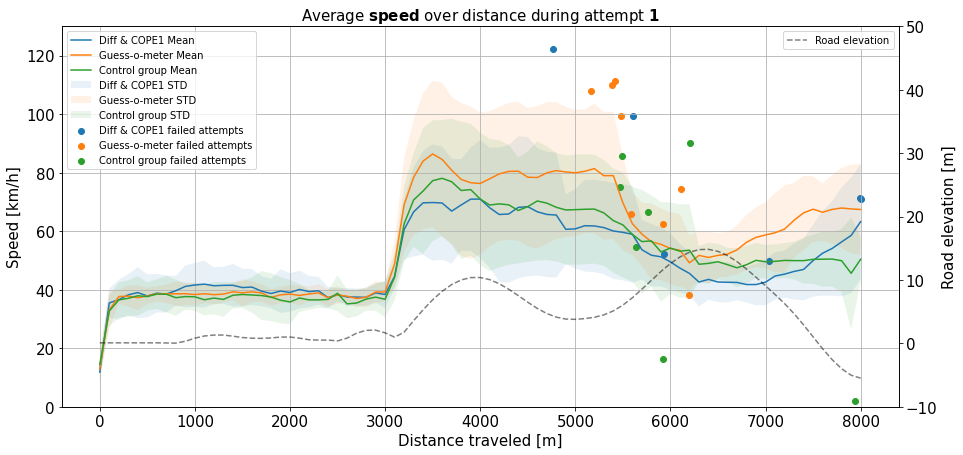

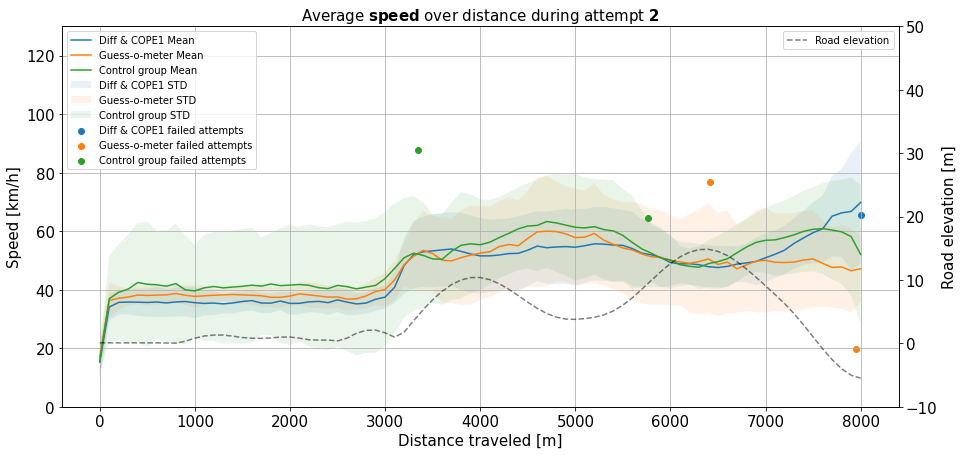

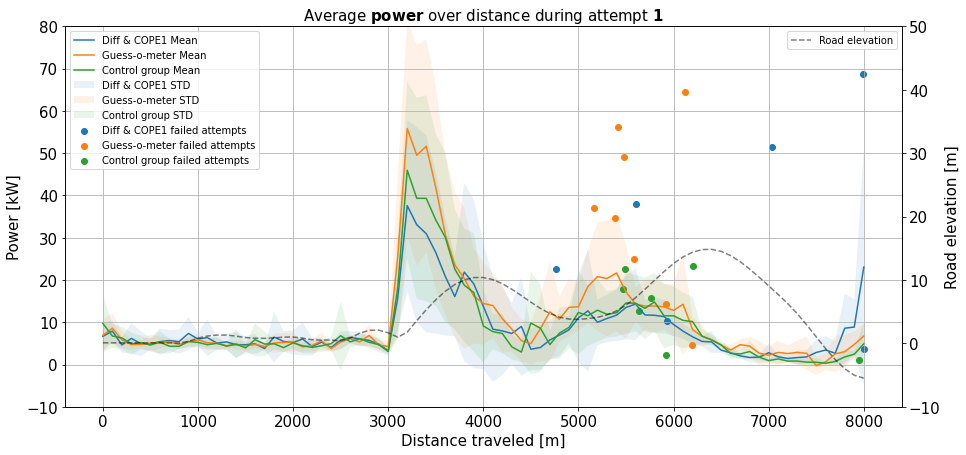

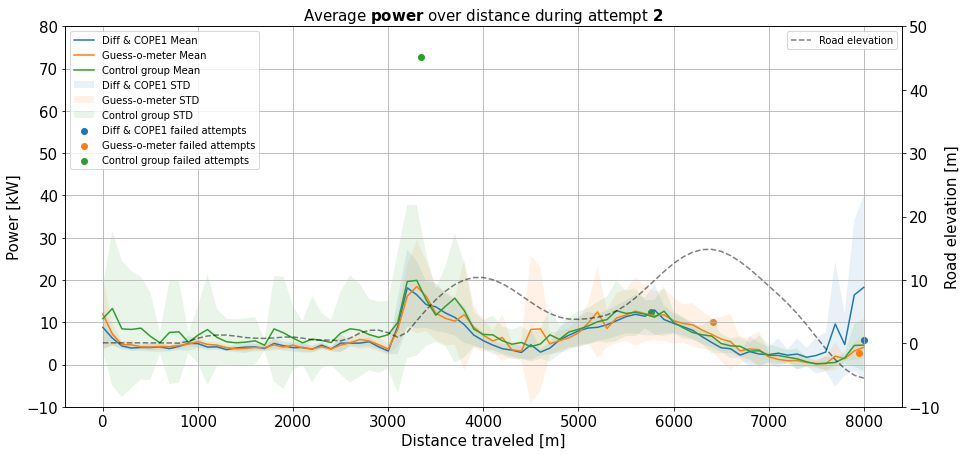

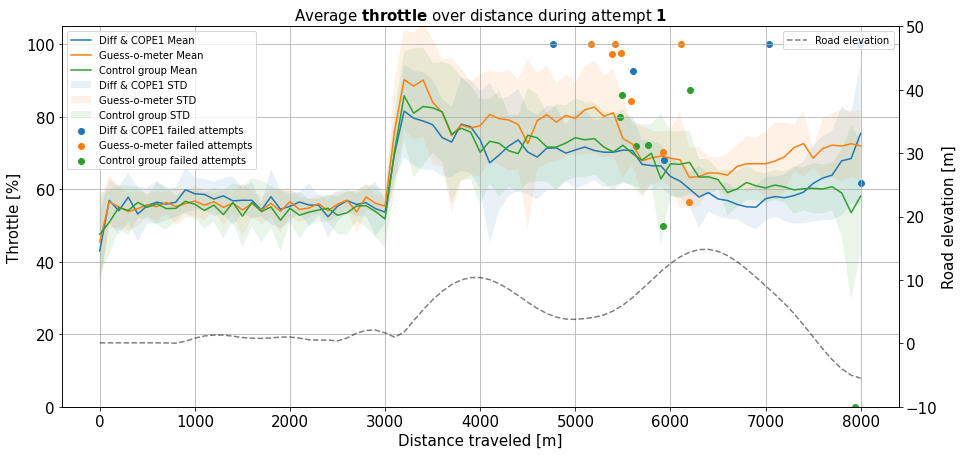

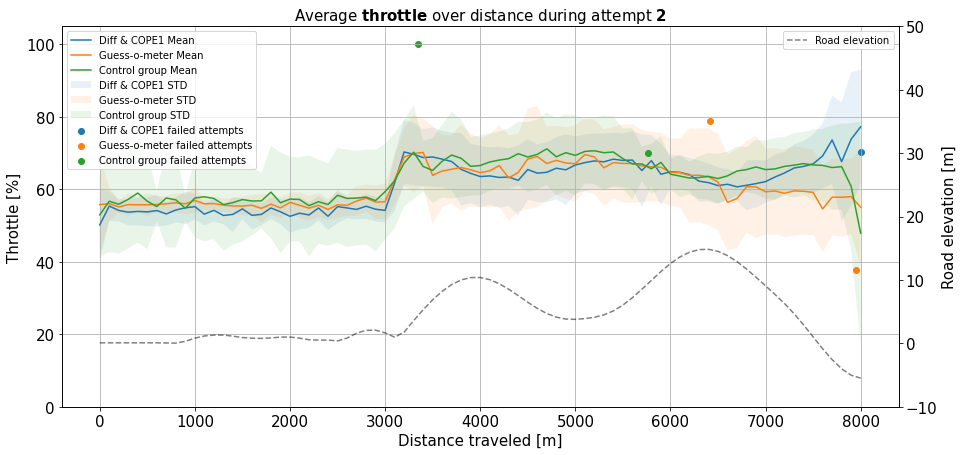

In [18]:
params = {
    'font.size': 12,
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'legend.fontsize': 10,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15
}
matplotlib.rcParams.update(params)

def plotGroupAverage(variable, attempt, save_images):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, ax = plt.subplots(figsize=(15,7))

  groups_average = average_groups[average_groups.attempt == attempt_nr]
  
  # Speed mean
  diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == attempt_nr)]
  plt.plot(diff_cope_mean.distance_window, diff_cope_mean[variable_to_plot], label="Diff & COPE1 Mean")
  
  guess_o_meter_mean = average_groups[(average_groups.evis_id == "guess_o_meter") & (average_groups.attempt == attempt_nr)]
  plt.plot(guess_o_meter_mean.distance_window, guess_o_meter_mean[variable_to_plot], label="Guess-o-meter Mean")

  control_group_mean = average_groups[(average_groups.evis_id == "control_group") & (average_groups.attempt == attempt_nr)]
  plt.plot(control_group_mean.distance_window, control_group_mean[variable_to_plot], label="Control group Mean")
  
  # speed STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  
  diff_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "diff_and_cope1")]
  plt.fill_between(
    diff_group_std.distance_window, 
    diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
    diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
    alpha=std_alpha, label="Diff & COPE1 STD")

  guess_o_meter_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "guess_o_meter")]
  plt.fill_between(
    guess_o_meter_mean.distance_window, 
    guess_o_meter_mean[variable_to_plot] + guess_o_meter_std[variable_to_plot],
    guess_o_meter_mean[variable_to_plot] - guess_o_meter_std[variable_to_plot],
    alpha=std_alpha, label="Guess-o-meter STD")
  
  control_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "control_group")]
  plt.fill_between(
    control_group_mean.distance_window, 
    control_group_mean[variable_to_plot] + control_group_std[variable_to_plot],
    control_group_mean[variable_to_plot] - control_group_std[variable_to_plot],
    alpha=std_alpha, label="Control group STD")
  
  # Fails
  plt.gca().set_prop_cycle(None)
  
  failed_diff_and_cope = failed_attempts[(failed_attempts.evis_id == "diff_and_cope1") & (failed_attempts.attempt == attempt_nr)]
  plt.scatter(failed_diff_and_cope.distance_traveled, failed_diff_and_cope[variable_to_plot], label="Diff & COPE1 failed attempts")

  failed_guess = failed_attempts[(failed_attempts.evis_id == "guess_o_meter") & (failed_attempts.attempt == attempt_nr)]
  plt.scatter(failed_guess.distance_traveled, failed_guess[variable_to_plot], label="Guess-o-meter failed attempts")

  failed_control_group = failed_attempts[(failed_attempts.evis_id == "control_group") & (failed_attempts.attempt == attempt_nr)]
  plt.scatter(failed_control_group.distance_traveled, failed_control_group[variable_to_plot], label="Control group failed attempts")

  # Road elevation
  road_evel_ax = ax.twinx()
  road_plot = road_evel_ax.plot(road_elevation.distance_window, road_elevation.road_elevation, "--", color="k", label="Road elevation", alpha=0.5)
  road_evel_ax.set_ylim(-10, 50)
  road_evel_ax.set_ylabel("Road elevation [m]")
  
  #title = "Average " + str(variable_to_plot) + " during attempt " + str(attempt_nr)
  #plt.title(title)
  
  tb1 = r"$\bf{" + variables_print_pretty[variable_to_plot].lower() + "}$"
  tb2 = r"$\bf{" + str(attempt) + "}$"

  ax.set_title("Average " + tb1 + " over distance during attempt " + tb2)
  
  ax.legend(loc="upper left")
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-10,80)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
    
  road_evel_ax.legend()
  ax.grid(True)
  ax.set_xlabel("Distance traveled [m]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])

  if save_images:
    plt.savefig("/home/steve/Pictures/figures/" + title + ".png", dpi=200)

  plt.show()
  
  
save_images = False
variable = "speed"
plotGroupAverage(variable, 1, save_images)
plotGroupAverage(variable, 2, save_images)
variable = "power_usage"
plotGroupAverage(variable, 1, save_images)
plotGroupAverage(variable, 2, save_images)
variable = "throttle_position"
plotGroupAverage(variable, 1, save_images)
plotGroupAverage(variable, 2, save_images)

## Plot EVIS individually

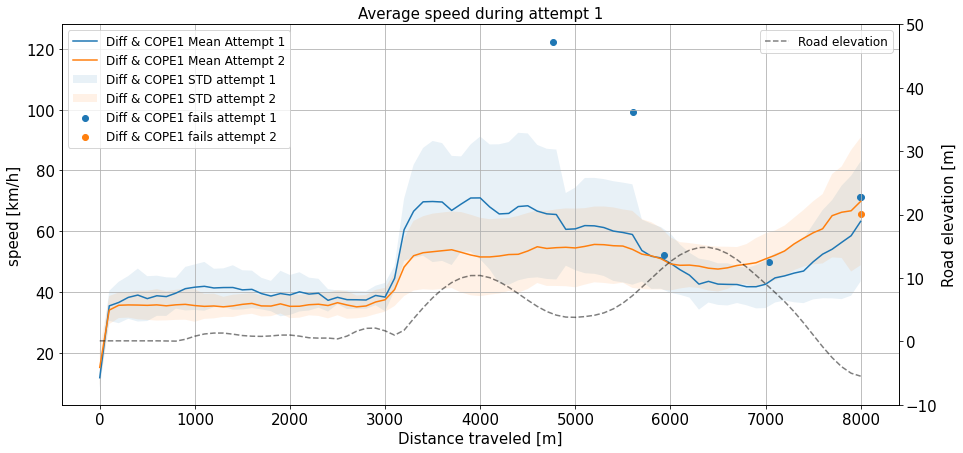

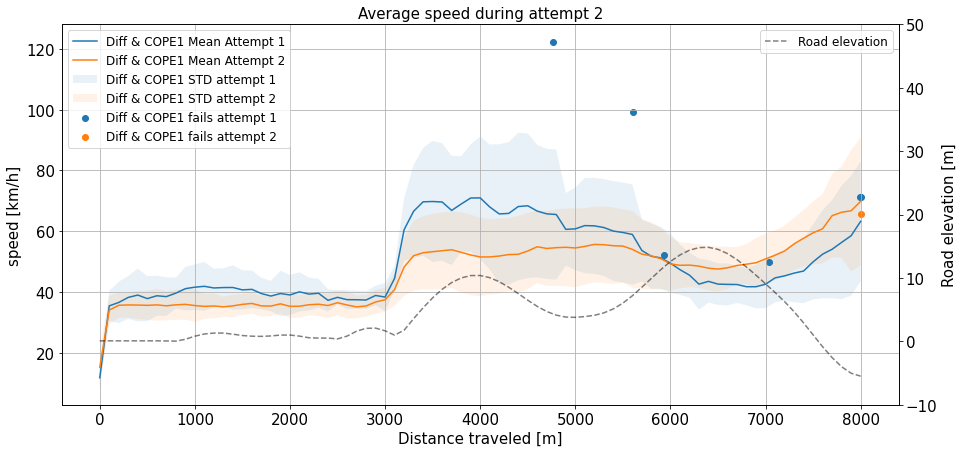

In [14]:
params = {
    'font.size': 12,
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15
}
matplotlib.rcParams.update(params)

def plotIndividualAverages(variable, attempt, save_images):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, ax = plt.subplots(figsize=(15,7))

  groups_average = average_groups[average_groups.attempt == attempt_nr]

  # Speed mean
  diff_cope_mean_1 = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == 1)]
  plt.plot(diff_cope_mean_1.distance_window, diff_cope_mean_1[variable_to_plot], label="Diff & COPE1 Mean Attempt 1")
  
  diff_cope_mean_2 = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == 2)]
  plt.plot(diff_cope_mean_2.distance_window, diff_cope_mean_2[variable_to_plot], label="Diff & COPE1 Mean Attempt 2")
   
  # speed STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  for i in range(2):
    diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == i+1)]
    diff_group_std = std_groups[(std_groups.attempt == i+1) & (std_groups.evis_id == "diff_and_cope1")]
    plt.fill_between(
      diff_group_std.distance_window, 
      diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
      diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
      alpha=std_alpha, label="Diff & COPE1 STD attempt " + str(i+1))
  
  # Fails
  plt.gca().set_prop_cycle(None)

  for i in range(2):
    failed_diff_and_cope = failed_attempts[(failed_attempts.evis_id == "diff_and_cope1") & (failed_attempts.attempt == i+1)]
    plt.scatter(failed_diff_and_cope.distance_traveled, failed_diff_and_cope[variable_to_plot], label="Diff & COPE1 fails attempt " + str(i+1))

  # Road elevation
  road_evel_ax = ax.twinx()
  road_plot = road_evel_ax.plot(road_elevation.distance_window, road_elevation.road_elevation, "--", color="k", label="Road elevation", alpha=0.5)
  road_evel_ax.set_ylim(-10, 50)
  road_evel_ax.set_ylabel("Road elevation [m]")
  
  title = "Average " + str(variable_to_plot) + " during attempt " + str(attempt_nr)
  plt.title(title)
  ax.legend(loc="upper left")
  #ax.set_ylim(0,130)
  road_evel_ax.legend()
  ax.grid(True)
  ax.set_xlabel("Distance traveled [m]")
  ax.set_ylabel(str(variable_to_plot) + " [km/h]")

  if save_images:
    plt.savefig("/home/steve/Pictures/figures/" + title + ".png", dpi=200)

  plt.show()
  
  
save_images = False
variable = "speed"
plotIndividualAverages(variable, 1, save_images)
plotIndividualAverages(variable, 2, save_images)

## Plot each driver individually
Here I plot each user's first and second attempt in individual plots

In [15]:
average_individual.groupby(["user_id"])

In [16]:
params = {
    'font.size': 12,
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15
}

matplotlib.rcParams.update(params)

def plotIndividualAverages(variable, save_images):
  variable_to_plot = variable
  
  counter = 0
  
  for id, data in average_individual.groupby(["user_id"]):
    fig, ax = plt.subplots(figsize=(15,7))
    
    evis = data["evis_id"].iloc[0] # Get which evis the driver is using
    attempt = data["attempt"].iloc[0] # Get which attempt
    
    a1 = data[data["attempt"] == 1]
    a2 = data[data["attempt"] == 2]
    
    plt.plot(a1.distance_window, a1[variable_to_plot] * 100, label="Attempt #1")
    plt.plot(a2.distance_window, a2[variable_to_plot] * 100, label="Attempt #2")
    
    # Road elevation
    ax_secondary = ax.twinx()
    ax_secondary.plot(road_elevation.distance_window, road_elevation.road_elevation, "--", color="k", label="Road elevation", alpha=0.3)
    ax_secondary.set_ylim(-10, 50)
    ax_secondary.set_ylabel("Road elevation [m]")
    
    ax_secondary.vlines(0,-100,200, "tab:olive", linewidth=2.0, linestyles="dotted", alpha=1.0, label="40 km/h road start")
    ax_secondary.vlines(3100,-100,200, "tab:cyan", linewidth=2.0, linestyles="dotted", alpha=1.0, label="110 km/h road start")
    ax_secondary.vlines(8000,-100,200, "tab:purple", linewidth=2.0, linestyles="dotted", alpha=1.0, label="Charging station")
        
    #tb1 = r"$\bf{" + str(variable_to_plot.capitalize()) + "}$"
    tb1 = r"$\bf{" + "Throttle" + "}$"
    tb2 = r"$\bf{" + "distance" + "}$"
    tb3 = r"$\bf{" + str(id) + "}$"
    tb4 = r"$\bf{" + variables_print_pretty[evis] + "}$"
    if(evis == "control_group"):
      evis_temp = variables_print_pretty[evis].split(" ")
      tb4 = r"$\bf{" + evis_temp[0] + "}$" + " " + r"$\bf{" + evis_temp[1] + "}$"
    
    ax.set_title(tb1 + " over " + tb2 + " for user with id " + tb3 + " using EVIS " + tb4)
    
    ax.grid(True)
    ax.set_xlabel("Distance traveled [km/h]")
    ax.set_ylabel("Throttle [%]")
    ax.set_ylim(0,105)
    #ax.set_ylim(0,1)
    ax.legend(loc="upper left", framealpha=1).set_zorder(200)
    ax_secondary.legend(loc="lower left", framealpha=1).set_zorder(100)
    plt.tight_layout()
    
    ax.set_zorder(1)
    ax_secondary.set_zorder(2)
    
    if True:
      file_name = str(id) + "_" + str(evis) + "_" + str(variable_to_plot)
      plt.savefig("/home/steve/Pictures/figures/individual_attempts/throttle/" + file_name + ".png", dpi=200)

    
    counter += 1

    #if counter > 2:
    #  return
  
  
save_images = False
variable = "throttle_position"
#plotIndividualAverages(variable, save_images)
